# PRS Analysis for WSL

Lukas Graz [](https://orcid.org/0009-0003-5147-8370) ([ETH Zurich](www.ethz.ch))  
February 25, 2025

For the **release notes** see the corresponding [GitHub](https://github.com/LGraz/wsl--prs-analysis/releases) page

# Data Preparation

## Train Test Split for Inference

Data was split into training and test sets (50/50) for hypothesis testing to ensure valid inference after feature selection.

## Missing Values

Missing value imputation was performed using MissForest doi:10.1093/bioinformatics/btr597. This method leverages conditional dependencies between variables to predict missing values through an iterative random forest approach.

To avoid introducing spurious correlations between different variable sets, we imputed the following data groups separately:

-   PRS variables on the complete dataset
-   Mediators on training data only
-   GIS variables on training data only
-   Mediators for prediction analysis
-   GIS variables for prediction analysis
-   PRS variables for prediction analysis

Mediators and GIS variables were intentionally not imputed on the test set to maintain valid inference, as MissForest does not provide a mechanism to propagate imputation uncertainty. An alternative would be the `mice`-routine, which could be implemented in future analyses. Missing values in the test set predictors remained untreated, which is justified under the missing completely at random (MCAR) assumption—where missing values occur independently of all other variables.

For the prediction analysis, fewer statistical assumptions are required, so using the MissForest approach does not violate any assumptions.

PRS variables could have been imputed separately for training/test sets and prediction analysis, but we prioritized simplicity as these variables serve only as response variables.

Additionally, we compared MissForest with simpler imputation methods (variable-wise and observation-wise mean imputation) for the PRS variables. Results confirmed that MissForest consistently outperformed these alternatives.

# Main Analysis

## Response Variable Selection

-   Aggregated mean
-   FA (Fascination)
-   BA (Being Away)
-   EC (Extent Coherence)
-   ES (Compatibility)

**PCA Verification** of this approach. Key findings:

-   Data can be well approximated with 3-4 dimensions
-   First dimension is close to weighted average of all variables (correlation \>0.99)
-   EC (Extent Coherence) shows most divergence (see PC2)
-   FA (Fascination) and BA (Being Away) show similarity (see PC1-PC3)
-   Aggregated PRS variables justified by PCA results (similar rotation values), supporting use of mean

## Prediction Analysis with Machine Learning Methods

Details and results in [the notebook](notebooks/mlr3.qmd).

This section investigates predictive relationships between Perceived Restorativeness Scale (PRS) variables, mediator variables, and Geographical Information System (GIS) variables using various machine learning approaches. We employed a systematic methodology to quantify the predictive power of different variable combinations.

### Methodological Approach

We evaluated multiple machine learning models using the mlr3 framework (cite doi:10.21105/joss.01903) :

-   Linear models (baseline)
-   XGBoost (gradient boosting with tree-based models and hyperparameter tuning for learning rate and tree depth) (cite arxiv:1603.02754)
-   Random Forests (with default parameters) (cite doi:10.1023/A:1010933404324)

Performance was measured as percentage of explained variance on hold-out data, calculated as (1 - MSE/Variance(y)), where MSE represents mean squared error.

### Model Combinations

To systematically explore predictive relationships, we tested four model configurations:

1.  PRS ~ GIS: Predicting PRS variables using only GIS variables
2.  PRS ~ GIS + Mediators: Predicting PRS variables using both GIS and mediator variables
3.  PRS ~ Mediators: Predicting PRS variables using only mediator variables
4.  Mediators ~ GIS: Predicting mediator variables using GIS variables

### Results

-   GIS shows limited predictive power for PRS on ES (5% variance explained)
-   GIS + Mediators explain 25% of PRS variance
-   Mediators alone explain majority of PRS variance
    -   GIS primarily helps with ES through tree-based methods
    -   Suggests GIS effect is more interaction-based than direct
    -   Similar reduction in tree-based methods observed in BA

## Hypothesis Testing: Investigation of Variable Effects on Perceived Restorativeness Scale

Details and results in [the notebook](notebooks/hypothethis-tests.qmd).

Here we investigated which variables (including their interactions) influence PRS variables using multiple linear regression. With 190 variables (counting interactions), the variance inflation factor (VIF) was high and the multiple testing problem severe. We therefore implemented a stepwise feature selection using Bayesian Information Criterion (BIC) on the training data, starting with an empty model to help computational complexity. Selected features were subsequently used to fit models on the test set to obtain valid p-values. To keep the coefficients interpretable in the presence of interactions, each variable is scaled to mean 0 and standard deviation 1.

### Model Specification and Analysis

The analysis systematically explored two key relationship pathways:

1.  Mediators ~ (GIS)² - examining how environmental features predict psychological mediators
2.  PRS ~ (Mediators + GIS)² - investigating how both environmental features and psychological mediators contribute to perceived restorativeness

For each target variable, we constructed a separate model using stepwise selection and evaluated it on the test dataset.

### Results

-   For HM_Noise (now removed): Continuous mediator outperforms categorical (scaled to mean 0, sd 1)
-   Full `mice` NA-handling likely unnecessary
    -   Models use few variables
    -   Only LNOISE shows high NA count
    -   Information detection still fails
-   Significant edges remain in SEM (see all interactions)

#### All Interactions: Mediators ~ (GIS)^2

Significant codes as usual: `0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1`

In [ ]:
readRDS("cache/ResSum3.rds")

  Covariate                 FEELNAT        LNOISE
  ---------------------- ------------- --------------
  (Intercept)                0.062         -0.001
  LCARTIF_sqrt            -0.152\*\*      -0.124\*
  LCARTIF_sqrt:RL_NDVI     0.115\*\*   
  OVDIST_sqrt                0.027     
  RL_NDVI                 0.150\*\*\*  
  RL_NOISE                              -0.242\*\*\*


#### PRS ~ (Mediators + GIS)^2

Significant codes as usual: `0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1`

In [ ]:
readRDS("cache/ResSum4.rds")

  Covariate            MEAN           FA            BA            EC           ES
  ---------------- ------------- ------------- ------------- ------------ -------------
  (Intercept)         -0.005         0.006        -0.008        -0.006        0.027
  DISTKM_sqrt         -0.019                                                 0.073.
  FEELNAT           0.252\*\*\*   0.266\*\*\*   0.252\*\*\*     0.058      0.270\*\*\*
  FEELNAT:LNOISE       0.022        -0.036                                
  LCFOREST_sqrt       -0.066.                                 -0.114\*\*  
  LNOISE            0.212\*\*\*   0.170\*\*\*                               0.142\*\*
  LNOISE:FEELNAT                                                             -0.013
  RL_NDVI                         -0.105\*\*                              


## Predict RL via HM

Details/Code and results in [the notebook](notebooks/RL-via-HM.qmd).

**Procedure:** Stepwise feature selection using BIC on training data and subsequent model fitting on test data. Performed seperately for `RL_NDVI` and `RL_NOISE`.

**Predictors:**: `HM_NDVI + HM_NOISE + LANG + AGE + SEX + SPEED_log + JNYTIME_sqrt` with all two-way interactions.

### RL_NDVI

``` python
lm_ndvi <- lm(RL_NDVI ~ (HM_NDVI + HM_NOISE + 
  #  ALONE + WITH_DOG + WITH_KID + WITH_PAR + WITH_PNT + WITH_FND +
   LANG + AGE + SEX +
   SPEED_log + JNYTIME_sqrt)^2, D_trn)
step_ndvi <- step(lm_ndvi, trace = FALSE, k = log(nrow(D_trn)))
summary(fit <- lm(formula(step_ndvi), D_tst))
```


    Call:
    lm(formula = formula(step_ndvi), data = D_tst)

    Residuals:
       Min     1Q Median     3Q    Max 
    -3.371 -0.430  0.182  0.698  1.989 

    Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
    (Intercept)        -0.1690     0.0946   -1.79  0.07452 .  
    HM_NDVI             0.1581     0.0413    3.83  0.00015 ***
    LANGGerman          0.2232     0.1064    2.10  0.03633 *  
    LANGItalian         0.0028     0.1965    0.01  0.98866    
    SPEED_log          -0.0720     0.0414   -1.74  0.08277 .  
    JNYTIME_sqrt        0.1272     0.0415    3.07  0.00226 ** 
    HM_NDVI:SPEED_log  -0.1848     0.0422   -4.38  1.4e-05 ***
    ---
    Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

    Residual standard error: 0.958 on 536 degrees of freedom
    Multiple R-squared:  0.0917,    Adjusted R-squared:  0.0815 
    F-statistic: 9.02 on 6 and 536 DF,  p-value: 2.09e-09

-   R² = 0.08
-   Higher HM_NDVI corresponds to slightly higher RL-NDVI
-   higher JNYTIME_sqrt corresponds to slightly higher RL-NDVI
-   The faster (or further) you travel to RL, the more the RL_NDVI differs from HM_NDVI (negative interaction effect)

### RL_NOISE

``` python
lm_noise <- lm(RL_NOISE ~ (HM_NDVI + HM_NOISE + 
  #  ALONE + WITH_DOG + WITH_KID + WITH_PAR + WITH_PNT + WITH_FND +
   LANG + AGE + SEX +
   SPEED_log + JNYTIME_sqrt)^2, D_trn)
step_noise <- step(lm_noise, trace = FALSE, k = log(nrow(D_trn)))
summary(lm(formula(step_noise), D_tst))
```


    Call:
    lm(formula = formula(step_noise), data = D_tst)

    Residuals:
        Min      1Q  Median      3Q     Max 
    -2.5097 -0.7495 -0.0467  0.6473  2.8683 

    Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
    (Intercept)           -0.03379    0.08896   -0.38  0.70426    
    HM_NOISE               0.23846    0.03916    6.09  2.2e-09 ***
    LANGGerman            -0.00494    0.09968   -0.05  0.96047    
    LANGItalian            0.62198    0.18667    3.33  0.00092 ***
    SPEED_log             -0.06326    0.03902   -1.62  0.10552    
    JNYTIME_sqrt          -0.31956    0.03936   -8.12  3.2e-15 ***
    HM_NOISE:JNYTIME_sqrt -0.03423    0.04070   -0.84  0.40061    
    ---
    Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

    Residual standard error: 0.904 on 536 degrees of freedom
    Multiple R-squared:  0.193, Adjusted R-squared:  0.184 
    F-statistic: 21.3 on 6 and 536 DF,  p-value: <2e-16

-   R² = 0.184
-   Participants can’t completely escape HM_NOISE (HM_NOISE positive predictor)
-   LANGItalians have it louder (than LANG de/fr)
-   Longer JNYTIME_sqrt leads to lower NOISE

Visualizing the effect of `HM_NOISE` and `JNYTIME_sqrt` on `RL_NOISE`:

``` python
# Plot with matching color scales
ggplot() +
  geom_raster(data = grid, aes(x = JNYTIME_sqrt, y = HM_NOISE, fill = predicted_RL_NOISE)) +
  geom_jitter(data = D_tst, aes(x = JNYTIME_sqrt, y = HM_NOISE, col = RL_NOISE, shape = LANG), 
              width = 0.07, height = 0.1, alpha = 0.7) +
  scale_fill_viridis_c(name = "Predicted\nRL_NOISE", limits = combined_range) +
  scale_color_viridis_c(name = "Actual\nRL_NOISE", limits = combined_range) 
```

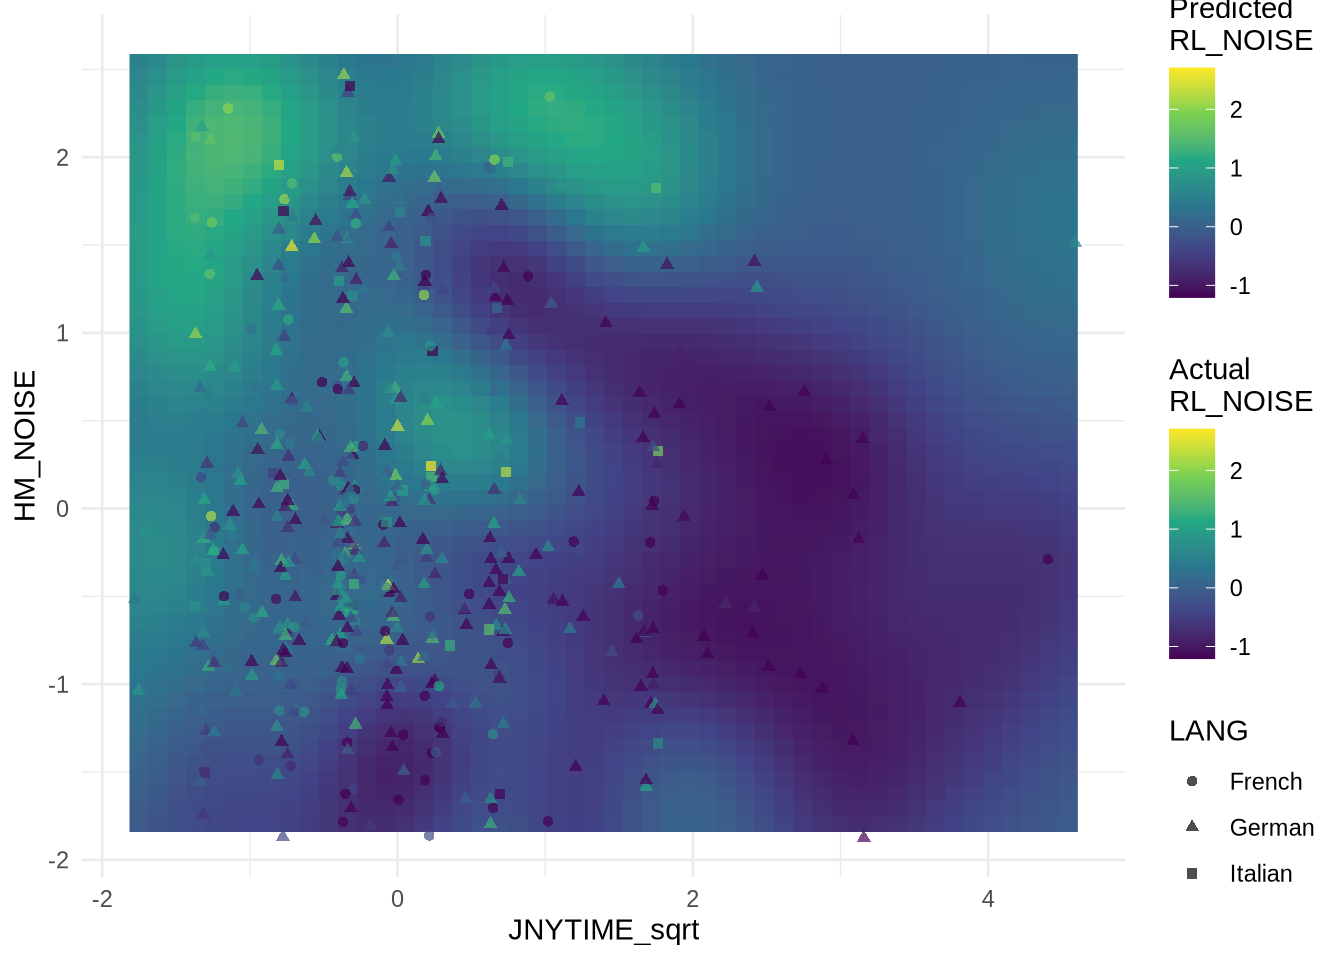

## Plots

see [the notebook](notebooks/noise-plots.qmd).